# STA414: HW1 Q3

**Date**: February 8, 2021  
**First Name**: Mahrukh  
**Last Name**: Niazi  
**Student Id**: 1003948204

In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame

### Generate Data:

In [2]:
# Generate data and lambda values:
data_train = {'X': np.genfromtxt('data_train_X.csv', delimiter=','),
              't': np.genfromtxt('data_train_y.csv', delimiter=',')}
data_test = {'X': np.genfromtxt('data_test_X.csv', delimiter=','),
             't': np.genfromtxt('data_test_y.csv', delimiter=',')}

lambda_seq = np.arange(0.02, 1.5, 0.03)

### Q3(a): Write the six functions.

**Last function `cross_validation` demonstrates the correct order and arguments to do cross validation using the five other helper functions.**

In [3]:
# Function Definitions:

def shuffle_data(data: tuple) -> tuple:
    """This function takes data as an argument and returns its randomly 
    permutated version along the samples.
    

    Inputs:
        - data: variable corresponding to the target vector (response) and 
                feature design matrix of the dataset, structured as a tuple.
    
    Outputs:
        - reshuffled dataset, maintaining the target and feature pair as a
          tuple of size two: the element at index 0 corresponds to the array
          of target responses and the element at index 1 corresponds to the
          array of feature matrix.

    """
    shuffled = {}
    p = np.random.permutation(len(data['X']))
    shuffled['X'], shuffled['t'] = data['X'][p], data['t'][p]

    return shuffled

def split_data(data: tuple, num_folds: int, fold: int) -> tuple:
    """This function takes data, number of partitions as num_folds, and the
    selected partition fold as its arguments and returns the selected 
    partition fold as data_fold, and the remaining data as data_rest. It 
    splits the dataset (training data) into num_fold - 1 training sets and 1
    validation set for a num_fold-cross validation algorithm. 
    
    Inputs:
        - data: variable corresponding to the target vector (response) and 
                feature design matrix of the dataset, structured as a tuple.
        
        - num_folds: integer corresponding to the k number of folds used for
                     cross validation.
        
        - fold: integer corresponding to the selected fold for the validation
                set.
    Output:
        - a tuple of size two: the element at index 0 corresponds to an
          array consisting of the selected validation set data_fold, and the
          element at index 1 corresponds to the array consisting of the 
          remaining folds for the training set data_rest for a num_folds 
          K-cross validation.
        
    """
    # Calculates the size of each fold
    sz_fold = int(len(data['t'])/num_folds)

    # Calculates the limits of validation fold
    idx_fold = list(range((fold-1)*sz_fold, fold*sz_fold-1))

    # Calculates the difference of the two sets
    idx_rest = list(set(range(0,len(data['t'])))-set(idx_fold))

    # Assign the correct portions of each folder set
    data_fold = {'X':data['X'][idx_fold,:],'t':data['t'][idx_fold]}
    data_rest = {'X':data['X'][idx_rest,:],'t':data['t'][idx_rest]}

    return(data_fold, data_rest)

def train_model(data, lambd: float) -> np.ndarray:
    """This function takes data and lambd as arguments, and returns the 
    coefficients of ridge regression with penalty level lambda.
    
    Inputs:
        - data: a tuple of size two, with element at index 0 corresponding to
                an array of target responses and element at index 1 
                corresponding to an array of feature matrix OR an array 
                corresponding to a specific fold from a pre-split k-fold cross 
                validation dataset. Data is assumed to be centered so no
                intercept is included. 
                
        - lambd: an integer for a specific lambda penalty value.
        
    Output:
        - an array consisting of the coefficient estimates derived from a 
          ridge regression.

    """
    xtx = np.matmul(np.transpose(data['X']), data['X'])
    inverse = np.linalg.inv(xtx + lambd * np.identity(len(data['X'][0])))

    return np.matmul(np.matmul(inverse, np.transpose(data['X'])), data['t'])
   

def predict(data, model: np.ndarray) -> np.ndarray:
    """This function takes data and model as its arguments, and returns the
    linear regression predicitons based on data and model.
    
    Inputs:
        - data: a tuple of size two, with element at index 0 corresponding to
                an array of target responses and element at index 1 
                corresponding to an array of feature matrix OR an array 
                corresponding to a specific fold from a pre-split k-fold cross 
                validation dataset.
        
        - model: an array consisting of the coefficient estimates derived from 
                 a ridge regression.
    
    Outputs:
        - an array consisting of the predictions derived from a linear ridge
          regression.
    """
    # predictions = np.matmul(data['X'],model)

    return data['X'].dot(model)
        
def loss(data, model: np.ndarray) -> float:
    """This function takes data and model as its arguments and returns the 
    average squared error loss based on model. With the following variables
    defined as: y = target response vector, X = feature design matrix,
    \beta = coefficients estimates vector, and n = sample size, the error loss
    equation is given by MSE = (1/n) ((y - X\beta)^2).
    
    Inputs:
        - data: a tuple of size two, with element at index 0 corresponding to
                an array of target responses and element at index 1 
                corresponding to an array of feature matrix OR an array 
                corresponding to a specific fold from a pre-split k-fold cross 
                validation dataset.
        
        - model: an array consisting of the coefficient estimates derived from 
                 a ridge regression.
    
    Outputs:
        - an array consisting of the MSE error derived from a linear ridge
          regression on the validation set.

    """
    # error = pow(np.linalg.norm(data['t']-np.matmul(data['X'],model)),2)/len(data['t'])

    return np.sum((data['t'] - predict(data, model)) ** 2) / len(data['t'])

def cross_validation(data: tuple, num_folds: int, lambd_seq: np.ndarray):
    """This function takes training data, number of folds num_folds, and a
    sequence of lambdas lambd_seq as its arguments and returns the cross
    validation error across all lambdas.

    Inputs:
        - data: variable corresponding to the target vector (response) and 
                feature design matrix of the training dataset, structured as a 
                tuple.
                
        - num_folds: integer corresponding to the k number of folds used for
                     cross validation.
        
        - lambd_seq: a sequence of evenly spaced lambda values over a 
                     specified intereval.
                     
    Output:
        - a list of cross validation errors across all specified lambda. 
          Length of list is the same as length of lambd_seq.

    """
    data = shuffle_data(data)
    cv_error = np.zeros(len(lambd_seq))

    for i in range(len(lambd_seq)):
        lambd = lambd_seq[i]
        cv_loss_lmd = 0.0
        for fold in range(num_folds):
            val_cv, train_cv = split_data(data, num_folds, fold)
            model = train_model(train_cv, lambd)
            cv_loss_lmd += loss(val_cv, model)
        cv_error[i] = (cv_loss_lmd / num_folds)
        
    return cv_error

### Q3(b): Dataframe of Training and Test Errors.

In [4]:
def training_test_errors(trainData, testData, lambd_seq):
    """This function takes the training set trainData and test set testData and
    returns the cross validation error across all lambdas for the adjusted model.
    
    Inputs:
        - trainData: training set
        
        - testData: test set
        
        - lambd_seq: a sequence of evenly spaced lambda values over a 
                     specified intereval.
    
    Outputs:
        - tuple of the training error and test error for each lambda
        
    """
    trainErrors = []
    testErrors = []
    
    for i in range(len(lambd_seq)):
        m = train_model(trainData, lambd_seq[i])
        trainE = loss(trainData, m)
        testE = loss(testData, m)
        trainErrors.append(trainE)
        testErrors.append(testE)
        
    return trainErrors, testErrors

trainErr, testErr = training_test_errors(data_train, data_test, lambda_seq)

from pandas import DataFrame
errors_df = DataFrame(trainErr, columns = ['Training Error'])
errors_df['Test Error'] = testErr
errors_df['Lambda Values'] = np.arange(0.02, 1.5, 0.03)
training_df = errors_df[['Lambda Values', 'Training Error', 'Test Error']]

print(errors_df)

    Training Error  Test Error  Lambda Values
0         0.049736    5.106960           0.02
1         0.105488    3.636285           0.05
2         0.153355    3.075622           0.08
3         0.196698    2.775597           0.11
4         0.237064    2.591344           0.14
5         0.275308    2.469397           0.17
6         0.311942    2.384996           0.20
7         0.347293    2.324998           0.23
8         0.381581    2.281745           0.26
9         0.414958    2.250458           0.29
10        0.447532    2.227998           0.32
11        0.479387    2.212213           0.35
12        0.510584    2.201576           0.38
13        0.541172    2.194978           0.41
14        0.571190    2.191590           0.44
15        0.600670    2.190781           0.47
16        0.629639    2.192064           0.50
17        0.658119    2.195055           0.53
18        0.686132    2.199449           0.56
19        0.713693    2.205002           0.59
20        0.740819    2.211515    

### Q3(b): Dataframes of 5-fold and 10-fold CV Error.

In [5]:
fiveFoldcv = cross_validation(data_train, 5, lambda_seq)
tenFoldcv = cross_validation(data_train, 10, lambda_seq)

cv_error = DataFrame(fiveFoldcv, columns = ['5-fold Cross Validation Error']) 
cv_error['10-fold Cross Validation Error'] = tenFoldcv
cv_error['Lambda Values'] = np.arange(0.02, 1.5, 0.03)
cv_error = cv_error[['Lambda Values', '5-fold Cross Validation Error', '10-fold Cross Validation Error']]
print(cv_error)

    Lambda Values  5-fold Cross Validation Error  \
0            0.02                       3.377419   
1            0.05                       2.881441   
2            0.08                       2.666061   
3            0.11                       2.549610   
4            0.14                       2.480733   
5            0.17                       2.438578   
6            0.20                       2.412914   
7            0.23                       2.398082   
8            0.26                       2.390689   
9            0.29                       2.388572   
10           0.32                       2.390290   
11           0.35                       2.394845   
12           0.38                       2.401529   
13           0.41                       2.409823   
14           0.44                       2.419344   
15           0.47                       2.429801   
16           0.50                       2.440972   
17           0.53                       2.452683   
18          

### Q3(c): Plot of CV Error Curve.

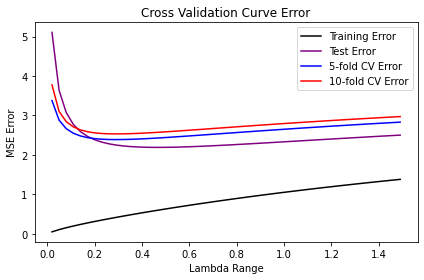

In [6]:
plt.plot(lambda_seq, trainErr, label="Training Error", color="black")
plt.plot(lambda_seq, testErr, label="Test Error", color="purple")
plt.plot(lambda_seq, fiveFoldcv, label="5-fold CV Error", color="blue")
plt.plot(lambda_seq, tenFoldcv, label="10-fold CV Error", color="red")

plt.title("Cross Validation Curve Error")
plt.xlabel("Lambda Range")
plt.ylabel("MSE Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Based on the plot, we can see that for the 5-fold, 10-fold, and Test data increasing lambda decreases error up to a point (minimum error) and then starts to increase as lambda increases. The minimum error for the 5-fold and 10-fold is close to that of the Test data, which suggests that using cross validation was good at finding a generalized parameter. 

On the other hand, the training error increases continuously. This is expected because when lambda equals 0 we get the non-penalized regression in which the MAP estimator coincides with the MLE estimator for the weight estimates.